#Import necessary libraries

In [39]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
import plotly.graph_objects as go

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

**Step 1: Dataset Acquisition**

- Begin by obtaining historical stock price data for AAPL. You can find this data from various financial sources, such as Yahoo Finance or a dedicated financial data provider.

- The dataset typically includes information such as Date, Open, High, Low, Close, Volume, and potentially other columns. For this project, we're primarily interested in the 'Close' price, which represents the closing price of AAPL stock for each trading day.

In [40]:
df = pd.read_csv('AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


**Step 2: Data Preprocessing**

- Load the acquired dataset into a Pandas DataFrame, a powerful data manipulation tool in Python.

- Convert the 'Date' column to a datetime data type and set it as the DataFrame's index. This enables us to work with time-series data effectively.

- Explore the dataset by printing the first few rows to understand its structure and contents. You can also use data.info() to obtain basic information about the dataset, including data types and missing values.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1258 non-null   int64  
 1   symbol       1258 non-null   object 
 2   date         1258 non-null   object 
 3   close        1258 non-null   float64
 4   high         1258 non-null   float64
 5   low          1258 non-null   float64
 6   open         1258 non-null   float64
 7   volume       1258 non-null   int64  
 8   adjClose     1258 non-null   float64
 9   adjHigh      1258 non-null   float64
 10  adjLow       1258 non-null   float64
 11  adjOpen      1258 non-null   float64
 12  adjVolume    1258 non-null   int64  
 13  divCash      1258 non-null   float64
 14  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(3), object(2)
memory usage: 147.5+ KB


#Visualizing Apple stock price from 2015 to 2021
**Step 3: Exploratory Data Analysis (EDA)**

- To gain insights into the data, perform exploratory data analysis.

- Visualize the AAPL stock price data over time using a line plot. This allows you to observe trends, patterns, and potential outliers in the historical prices.

- Calculate and visualize daily returns, which show how much the stock price changes from one day to the next. This helps identify periods of growth and decline.

In [42]:
#figure(figsize=(8, 6), dpi=80)
fig1 = go.Figure(data=[go.Candlestick(x=df["date"],
                                        open=df["open"],
                                        high=df["high"],
                                        low=df["low"],
                                        close=df["close"])])
fig1.update_layout(title = "Apple Stock Price Analysis", xaxis_rangeslider_visible=True)
fig1.show()

#Visualizing daily returns of Apple stock

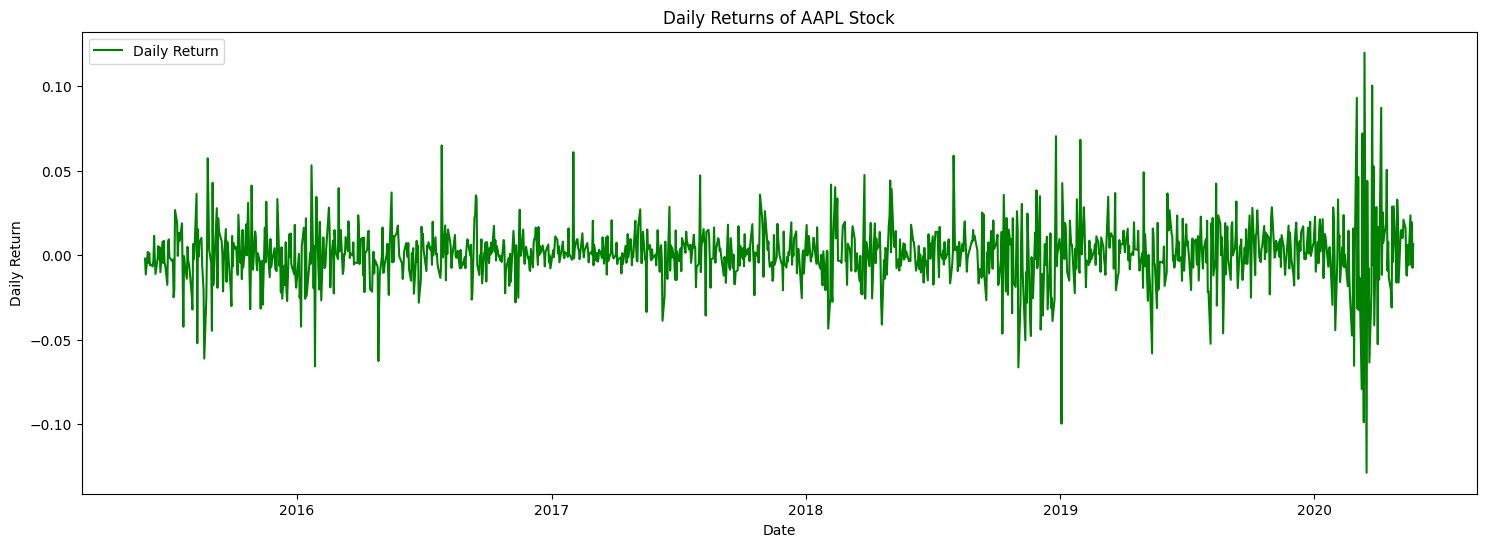

In [43]:
df2 = pd.read_csv('AAPL.csv')
df2['Date'] = pd.to_datetime(df2['date'])
df2.set_index('Date', inplace=True)

# Calculate and visualize daily returns
df2['Daily_Return'] = df2['close'].pct_change()
plt.figure(figsize=(18, 6))
plt.title('Daily Returns of AAPL Stock')
plt.plot(df2.index, df2['Daily_Return'], label='Daily Return', color='green')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

#Data scaling
**Step 4: Data Normalization**

Normalize the 'Close' price data using Min-Max scaling. This scaling technique transforms the values to a consistent range between 0 and 1, making it easier for the neural network to learn.

In [44]:
#Scale the data
df1=df.reset_index()['close']
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


#Splitting dataset into train and test sets
**Step 5: Data Splitting**

- Split the normalized data into training and testing sets. In this project, we use 80% of the data for training and the remaining 20% for testing. This separation allows us to evaluate the model's performance on unseen data.

In [45]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

print(training_size)
print(test_size)

817
441


In [46]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [47]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [48]:
print(X_train.shape)
print(y_train.shape)

(716, 100)
(716,)


In [49]:
print(X_test.shape)
print(y_test.shape)

(340, 100)
(340,)


In [50]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#Building the Stacked LSTM model
**Step 6: Model Building**

- Define the architecture of the LSTM (Long Short-Term Memory) model. LSTMs are well-suited for time series prediction tasks because they can capture long-term dependencies.

- Create a stacked LSTM model with multiple LSTM layers. Stacked LSTMs can capture complex temporal patterns in the data.

**Step 7: Model Compilation**

- Compile the LSTM model by specifying the optimizer and loss function. In this case, we use the 'adam' optimizer and mean squared error (MSE) as the loss function. MSE is commonly used for regression tasks like stock price prediction.

In [51]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#Stacked LSTM model training for 200 epochs
**Step 8: Model Training**

- Train the LSTM model using the training dataset. During training, the model learns to make predictions based on the historical stock price data.
Monitor the training process, including changes in training and validation loss, over multiple training epochs.

- I am training the model for 200 epochs

In [53]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
12/12 [==============================] - 11s 386ms/step - loss: 0.0198 - val_loss: 0.0486
Epoch 2/200
12/12 [==============================] - 2s 201ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 3/200
12/12 [==============================] - 2s 200ms/step - loss: 0.0011 - val_loss: 0.0075
Epoch 4/200
12/12 [==============================] - 2s 203ms/step - loss: 9.0648e-04 - val_loss: 0.0040
Epoch 5/200
12/12 [==============================] - 4s 305ms/step - loss: 7.8209e-04 - val_loss: 0.0046
Epoch 6/200
12/12 [==============================] - 3s 249ms/step - loss: 6.5783e-04 - val_loss: 0.0039
Epoch 7/200
12/12 [==============================] - 2s 204ms/step - loss: 6.5943e-04 - val_loss: 0.0041
Epoch 8/200
12/12 [==============================] - 2s 200ms/step - loss: 6.2213e-04 - val_loss: 0.0040
Epoch 9/200
12/12 [==============================] - 3s 216ms/step - loss: 6.2725e-04 - val_loss: 0.0040
Epoch 10/200
12/12 [==============================] - 3s 286ms/ste

**Step 9: Model Evaluation** (Not performed)

- After training, you can evaluate the model's performance on the testing dataset to assess how well it generalizes to unseen data. However, this project focuses on prediction and visualization.

#Predicting future stock price of Apple
**Step 10: Prediction**

- Utilize the trained LSTM model to make predictions on the testing dataset. Predictions are generated in sequences of data points.

In [54]:
#Predict and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 39ms/step


**Step 11: Inverse Scaling**

- Inverse transform the predicted and actual values to bring them back to their original scale (USD) from the normalized scale. This step is crucial for comparing predictions with actual stock prices.

In [55]:
#Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [56]:
#Calculate RMSE performance metrics
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

141.76732190056654
239.23874721725508


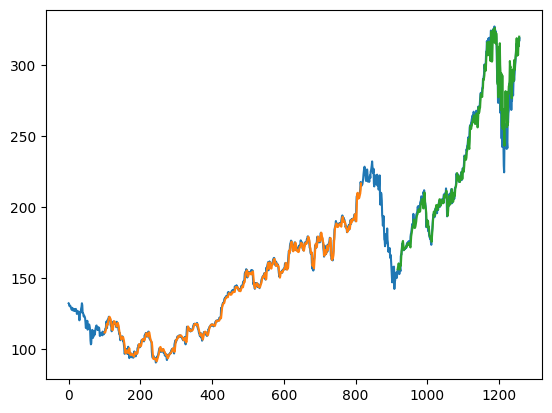

In [57]:
#Plotting the results
#figure(figsize=(8, 6), dpi=80)
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [65]:
# demonstrate prediction for the next 30 days
x_input=test_data[341:].reshape(1,-1)
print(x_input.shape)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

(1, 100)


In [59]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
print(len(df1))

1258


#Visualizing the price predictions for the next 30 days
**Step 12: Result Visualization**

- Finally, visualize the actual and predicted stock prices over time. Plotting these values on a graph allows you to assess how effectively the LSTM model predicts future stock prices based on historical data.

Text(0.5, 1.0, 'Stock price prediction for the next 30 days')

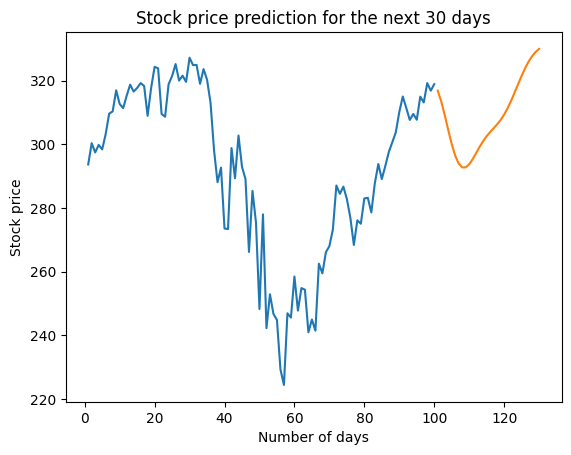

In [66]:
#Prediction plot for the next 30 days
#figure(figsize=(8, 6), dpi=80)
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.xlabel("Number of days")
plt.ylabel("Stock price")
plt.title("Stock price prediction for the next 30 days")

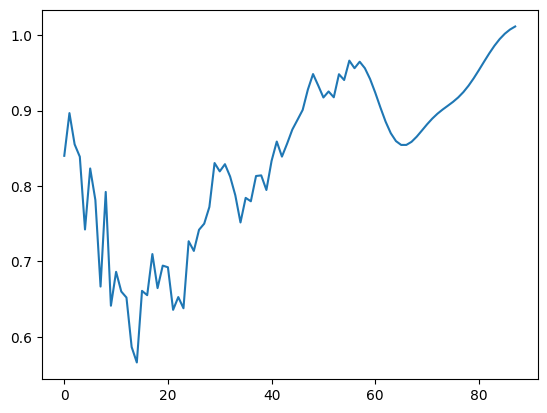

In [61]:
#Prediction plot for the next 30 days
#figure(figsize=(8, 6), dpi=80)
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

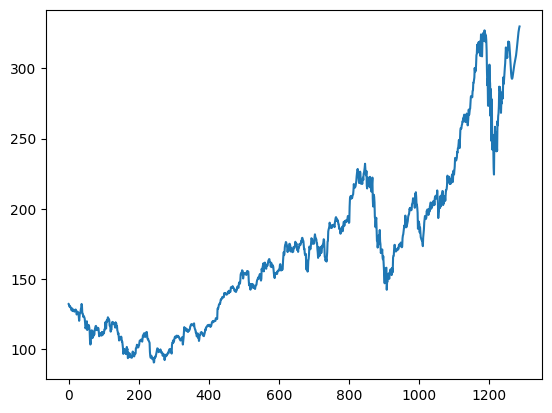

In [62]:
#Final plot with the prediction for next 30 days
#figure(figsize=(8, 6), dpi=80)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)